In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-31 03:25:02--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.18
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  14.5MB/s    in 23s     

2022-05-31 03:25:26 (13.6 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1000,10000),cutout_ratio=[(0,1)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-31 03:25:27,720 - mmseg - INFO - Loaded 537 images
2022-05-31 03:25:33,078 - mmseg - INFO - Loaded 113 images
2022-05-31 03:25:33,083 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-31 03:25:33,661 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-31 03:25:33,673 - mmseg - INFO - Start running, host: root@fa5f14a82cac, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1
2022-05-31 03:25:33,675 - mmseg - INFO - Hooks will be execu

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 734s, ETA:     0s

2022-05-31 03:44:59,822 - mmseg - INFO - per class results:
2022-05-31 03:44:59,825 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 83.42 | 86.47 |
|  building  | 69.67 | 86.38 |
|  Boundary  | 44.19 | 69.15 |
+------------+-------+-------+
2022-05-31 03:44:59,827 - mmseg - INFO - Summary:
2022-05-31 03:44:59,830 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.02 | 65.76 | 80.67 |
+-------+-------+-------+
2022-05-31 03:44:59,833 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8402, mIoU: 0.6576, mAcc: 0.8067, IoU.background: 0.8342, IoU.building: 0.6967, IoU.Boundary: 0.4419, Acc.background: 0.8647, Acc.building: 0.8638, Acc.Boundary: 0.6915
2022-05-31 03:45:45,220 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 5:46:54, time: 7.794, data_time: 7.371, memory: 3323, decode.loss_dice: 0.1979, decode.loss_focal: 0.0424, decode.loss_lovasz: 0.3709, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 733s, ETA:     0s

2022-05-31 04:04:31,810 - mmseg - INFO - per class results:
2022-05-31 04:04:31,812 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.07 | 91.92 |
|  building  | 74.48 | 89.46 |
|  Boundary  |  46.8 | 63.68 |
+------------+-------+-------+
2022-05-31 04:04:31,813 - mmseg - INFO - Summary:
2022-05-31 04:04:31,817 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.37 | 69.78 | 81.69 |
+-------+-------+-------+
2022-05-31 04:04:31,820 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8737, mIoU: 0.6978, mAcc: 0.8169, IoU.background: 0.8807, IoU.building: 0.7448, IoU.Boundary: 0.4680, Acc.background: 0.9192, Acc.building: 0.8946, Acc.Boundary: 0.6368
2022-05-31 04:05:14,109 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 5:38:09, time: 7.755, data_time: 7.338, memory: 3323, decode.loss_dice: 0.1975, decode.loss_focal: 0.0464, decode.loss_lovasz: 0.3666, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 733s, ETA:     0s

2022-05-31 04:23:58,224 - mmseg - INFO - per class results:
2022-05-31 04:23:58,226 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.58 | 92.76 |
|  building  | 75.55 | 86.43 |
|  Boundary  | 49.74 | 69.65 |
+------------+-------+-------+
2022-05-31 04:23:58,228 - mmseg - INFO - Summary:
2022-05-31 04:23:58,230 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.99 | 71.29 | 82.95 |
+-------+-------+-------+
2022-05-31 04:23:58,233 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8799, mIoU: 0.7129, mAcc: 0.8295, IoU.background: 0.8858, IoU.building: 0.7555, IoU.Boundary: 0.4974, Acc.background: 0.9276, Acc.building: 0.8643, Acc.Boundary: 0.6965
2022-05-31 04:24:40,513 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 5:22:15, time: 7.758, data_time: 7.341, memory: 3323, decode.loss_dice: 0.1692, decode.loss_focal: 0.0406, decode.loss_lovasz: 0.3335, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 734s, ETA:     0s

2022-05-31 04:43:25,281 - mmseg - INFO - per class results:
2022-05-31 04:43:25,283 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.25 | 93.46 |
|  building  |  76.9 | 86.74 |
|  Boundary  | 51.12 | 70.64 |
+------------+-------+-------+
2022-05-31 04:43:25,284 - mmseg - INFO - Summary:
2022-05-31 04:43:25,286 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.64 | 72.42 | 83.61 |
+-------+-------+-------+
2022-05-31 04:43:25,292 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8864, mIoU: 0.7242, mAcc: 0.8361, IoU.background: 0.8925, IoU.building: 0.7690, IoU.Boundary: 0.5112, Acc.background: 0.9346, Acc.building: 0.8674, Acc.Boundary: 0.7064
2022-05-31 04:44:07,440 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 5:04:39, time: 7.767, data_time: 7.351, memory: 3323, decode.loss_dice: 0.1652, decode.loss_focal: 0.0443, decode.loss_lovasz: 0.3276, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 733s, ETA:     0s

2022-05-31 05:02:50,042 - mmseg - INFO - per class results:
2022-05-31 05:02:50,044 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.67 | 94.26 |
|  building  | 77.23 |  87.1 |
|  Boundary  | 51.87 | 69.32 |
+------------+-------+-------+
2022-05-31 05:02:50,046 - mmseg - INFO - Summary:
2022-05-31 05:02:50,049 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.03 | 72.92 | 83.56 |
+-------+-------+-------+
2022-05-31 05:02:50,051 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8903, mIoU: 0.7292, mAcc: 0.8356, IoU.background: 0.8967, IoU.building: 0.7723, IoU.Boundary: 0.5187, Acc.background: 0.9426, Acc.building: 0.8710, Acc.Boundary: 0.6932
2022-05-31 05:03:32,421 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 4:46:14, time: 7.753, data_time: 7.336, memory: 3323, decode.loss_dice: 0.1547, decode.loss_focal: 0.0367, decode.loss_lovasz: 0.3084, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 751s, ETA:     0s

2022-05-31 05:22:36,648 - mmseg - INFO - per class results:
2022-05-31 05:22:36,650 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.83 | 94.29 |
|  building  | 77.45 | 86.07 |
|  Boundary  | 52.13 | 71.31 |
+------------+-------+-------+
2022-05-31 05:22:36,652 - mmseg - INFO - Summary:
2022-05-31 05:22:36,655 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.08 | 73.14 | 83.89 |
+-------+-------+-------+
2022-05-31 05:22:36,657 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8908, mIoU: 0.7314, mAcc: 0.8389, IoU.background: 0.8983, IoU.building: 0.7745, IoU.Boundary: 0.5213, Acc.background: 0.9429, Acc.building: 0.8607, Acc.Boundary: 0.7131
2022-05-31 05:23:19,115 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 4:28:19, time: 7.939, data_time: 7.520, memory: 3323, decode.loss_dice: 0.1524, decode.loss_focal: 0.0373, decode.loss_lovasz: 0.3067, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 752s, ETA:     0s

2022-05-31 05:42:23,224 - mmseg - INFO - per class results:
2022-05-31 05:42:23,226 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.98 |  94.3 |
|  building  | 78.06 | 88.67 |
|  Boundary  | 51.84 |  68.3 |
+------------+-------+-------+
2022-05-31 05:42:23,227 - mmseg - INFO - Summary:
2022-05-31 05:42:23,232 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.29 | 73.29 | 83.76 |
+-------+-------+-------+
2022-05-31 05:42:23,233 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8929, mIoU: 0.7329, mAcc: 0.8376, IoU.background: 0.8998, IoU.building: 0.7806, IoU.Boundary: 0.5184, Acc.background: 0.9430, Acc.building: 0.8867, Acc.Boundary: 0.6830
2022-05-31 05:43:05,843 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 4:09:53, time: 7.950, data_time: 7.530, memory: 3323, decode.loss_dice: 0.1406, decode.loss_focal: 0.0325, decode.loss_lovasz: 0.2885, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 752s, ETA:     0s

2022-05-31 06:02:06,609 - mmseg - INFO - per class results:
2022-05-31 06:02:06,611 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.45 | 94.19 |
|  building  | 75.26 |  83.1 |
|  Boundary  | 51.95 |  71.2 |
+------------+-------+-------+
2022-05-31 06:02:06,614 - mmseg - INFO - Summary:
2022-05-31 06:02:06,617 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.28 | 71.89 | 82.83 |
+-------+-------+-------+
2022-05-31 06:02:06,619 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8828, mIoU: 0.7189, mAcc: 0.8283, IoU.background: 0.8845, IoU.building: 0.7526, IoU.Boundary: 0.5195, Acc.background: 0.9419, Acc.building: 0.8310, Acc.Boundary: 0.7120
2022-05-31 06:02:51,706 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 3:51:05, time: 7.971, data_time: 7.550, memory: 3323, decode.loss_dice: 0.1363, decode.loss_focal: 0.0334, decode.loss_lovasz: 0.2847, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 751s, ETA:     0s

2022-05-31 06:21:52,160 - mmseg - INFO - per class results:
2022-05-31 06:21:52,162 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  89.7 | 94.35 |
|  building  | 77.84 | 87.45 |
|  Boundary  | 52.58 | 69.76 |
+------------+-------+-------+
2022-05-31 06:21:52,164 - mmseg - INFO - Summary:
2022-05-31 06:21:52,166 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.23 | 73.38 | 83.85 |
+-------+-------+-------+
2022-05-31 06:21:52,169 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8923, mIoU: 0.7338, mAcc: 0.8385, IoU.background: 0.8970, IoU.building: 0.7784, IoU.Boundary: 0.5258, Acc.background: 0.9435, Acc.building: 0.8745, Acc.Boundary: 0.6976
2022-05-31 06:22:34,974 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 3:32:02, time: 7.937, data_time: 7.515, memory: 3323, decode.loss_dice: 0.1407, decode.loss_focal: 0.0360, decode.loss_lovasz: 0.2894, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 731s, ETA:     0s

2022-05-31 06:41:17,889 - mmseg - INFO - per class results:
2022-05-31 06:41:17,893 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.24 | 94.28 |
|  building  |  78.7 |  87.3 |
|  Boundary  | 53.61 | 72.76 |
+------------+-------+-------+
2022-05-31 06:41:17,895 - mmseg - INFO - Summary:
2022-05-31 06:41:17,898 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.58 | 74.18 | 84.78 |
+-------+-------+-------+
2022-05-31 06:41:17,902 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8958, mIoU: 0.7418, mAcc: 0.8478, IoU.background: 0.9024, IoU.building: 0.7870, IoU.Boundary: 0.5361, Acc.background: 0.9428, Acc.building: 0.8730, Acc.Boundary: 0.7276
2022-05-31 06:42:00,186 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 3:12:32, time: 7.729, data_time: 7.312, memory: 3323, decode.loss_dice: 0.1376, decode.loss_focal: 0.0325, decode.loss_lovasz: 0.2837, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 725s, ETA:     0s

2022-05-31 07:00:35,054 - mmseg - INFO - per class results:
2022-05-31 07:00:35,056 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.94 | 92.99 |
|  building  | 79.04 |  90.8 |
|  Boundary  | 51.79 | 70.36 |
+------------+-------+-------+
2022-05-31 07:00:35,058 - mmseg - INFO - Summary:
2022-05-31 07:00:35,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.29 | 73.59 | 84.71 |
+-------+-------+-------+
2022-05-31 07:00:35,065 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8929, mIoU: 0.7359, mAcc: 0.8471, IoU.background: 0.8994, IoU.building: 0.7904, IoU.Boundary: 0.5179, Acc.background: 0.9299, Acc.building: 0.9080, Acc.Boundary: 0.7036
2022-05-31 07:01:17,571 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:52:58, time: 7.680, data_time: 7.261, memory: 3323, decode.loss_dice: 0.1401, decode.loss_focal: 0.0342, decode.loss_lovasz: 0.2901, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 07:19:52,484 - mmseg - INFO - per class results:
2022-05-31 07:19:52,486 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.53 | 95.03 |
|  building  | 78.34 | 86.31 |
|  Boundary  | 53.86 | 72.16 |
+------------+-------+-------+
2022-05-31 07:19:52,488 - mmseg - INFO - Summary:
2022-05-31 07:19:52,490 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.71 | 74.24 | 84.5 |
+-------+-------+------+
2022-05-31 07:19:52,494 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8971, mIoU: 0.7424, mAcc: 0.8450, IoU.background: 0.9053, IoU.building: 0.7834, IoU.Boundary: 0.5386, Acc.background: 0.9503, Acc.building: 0.8631, Acc.Boundary: 0.7216
2022-05-31 07:20:34,915 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 2:33:26, time: 7.686, data_time: 7.268, memory: 3323, decode.loss_dice: 0.1263, decode.loss_focal: 0.0304, decode.loss_lovasz: 0.2662, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 07:39:10,868 - mmseg - INFO - per class results:
2022-05-31 07:39:10,871 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.0 | 93.27 |
|  building  | 78.81 | 89.18 |
|  Boundary  |  53.1 | 72.68 |
+------------+-------+-------+
2022-05-31 07:39:10,873 - mmseg - INFO - Summary:
2022-05-31 07:39:10,874 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.4 | 73.97 | 85.04 |
+------+-------+-------+
2022-05-31 07:39:10,879 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8940, mIoU: 0.7397, mAcc: 0.8504, IoU.background: 0.9000, IoU.building: 0.7881, IoU.Boundary: 0.5310, Acc.background: 0.9327, Acc.building: 0.8918, Acc.Boundary: 0.7268
2022-05-31 07:39:52,944 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 2:13:57, time: 7.679, data_time: 7.265, memory: 3323, decode.loss_dice: 0.1327, decode.loss_focal: 0.0308, decode.loss_lovasz: 0.2776, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 07:58:29,219 - mmseg - INFO - per class results:
2022-05-31 07:58:29,221 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.59 | 94.39 |
|  building  | 78.84 | 87.65 |
|  Boundary  | 53.89 | 72.93 |
+------------+-------+-------+
2022-05-31 07:58:29,225 - mmseg - INFO - Summary:
2022-05-31 07:58:29,228 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.75 | 74.44 | 84.99 |
+-------+-------+-------+
2022-05-31 07:58:29,230 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8975, mIoU: 0.7444, mAcc: 0.8499, IoU.background: 0.9059, IoU.building: 0.7884, IoU.Boundary: 0.5389, Acc.background: 0.9439, Acc.building: 0.8765, Acc.Boundary: 0.7293
2022-05-31 07:59:11,439 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:54:29, time: 7.682, data_time: 7.266, memory: 3323, decode.loss_dice: 0.1270, decode.loss_focal: 0.0319, decode.loss_lovasz: 0.2677, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 08:17:44,293 - mmseg - INFO - per class results:
2022-05-31 08:17:44,295 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.54 | 94.23 |
|  building  |  79.2 |  88.9 |
|  Boundary  | 53.61 | 71.71 |
+------------+-------+-------+
2022-05-31 08:17:44,298 - mmseg - INFO - Summary:
2022-05-31 08:17:44,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.78 | 74.45 | 84.95 |
+-------+-------+-------+
2022-05-31 08:17:44,305 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8978, mIoU: 0.7445, mAcc: 0.8495, IoU.background: 0.9054, IoU.building: 0.7920, IoU.Boundary: 0.5361, Acc.background: 0.9423, Acc.building: 0.8890, Acc.Boundary: 0.7171
2022-05-31 08:18:28,678 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:35:03, time: 7.705, data_time: 7.288, memory: 3323, decode.loss_dice: 0.1236, decode.loss_focal: 0.0305, decode.loss_lovasz: 0.2626, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 725s, ETA:     0s

2022-05-31 08:37:02,424 - mmseg - INFO - per class results:
2022-05-31 08:37:02,426 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.66 | 93.86 |
|  building  | 79.21 | 88.85 |
|  Boundary  | 54.25 | 73.79 |
+------------+-------+-------+
2022-05-31 08:37:02,428 - mmseg - INFO - Summary:
2022-05-31 08:37:02,434 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.83 | 74.71 | 85.5 |
+-------+-------+------+
2022-05-31 08:37:02,435 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8983, mIoU: 0.7471, mAcc: 0.8550, IoU.background: 0.9066, IoU.building: 0.7921, IoU.Boundary: 0.5425, Acc.background: 0.9386, Acc.building: 0.8885, Acc.Boundary: 0.7379
2022-05-31 08:37:44,942 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 1:15:37, time: 7.678, data_time: 7.259, memory: 3323, decode.loss_dice: 0.1242, decode.loss_focal: 0.0329, decode.loss_lovasz: 0.2617, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 08:56:22,561 - mmseg - INFO - per class results:
2022-05-31 08:56:22,566 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.82 | 94.28 |
|  building  | 79.62 |  88.8 |
|  Boundary  | 54.62 | 73.43 |
+------------+-------+-------+
2022-05-31 08:56:22,570 - mmseg - INFO - Summary:
2022-05-31 08:56:22,572 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 90.03 | 75.02 | 85.5 |
+-------+-------+------+
2022-05-31 08:56:22,575 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9003, mIoU: 0.7502, mAcc: 0.8550, IoU.background: 0.9082, IoU.building: 0.7962, IoU.Boundary: 0.5462, Acc.background: 0.9428, Acc.building: 0.8880, Acc.Boundary: 0.7343
2022-05-31 08:57:04,753 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:56:13, time: 7.685, data_time: 7.270, memory: 3323, decode.loss_dice: 0.1255, decode.loss_focal: 0.0315, decode.loss_lovasz: 0.2671, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 09:15:42,575 - mmseg - INFO - per class results:
2022-05-31 09:15:42,577 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.74 | 94.19 |
|  building  | 79.28 | 88.29 |
|  Boundary  | 54.42 | 73.82 |
+------------+-------+-------+
2022-05-31 09:15:42,579 - mmseg - INFO - Summary:
2022-05-31 09:15:42,582 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.91 | 74.81 | 85.43 |
+-------+-------+-------+
2022-05-31 09:15:42,585 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8991, mIoU: 0.7481, mAcc: 0.8543, IoU.background: 0.9074, IoU.building: 0.7928, IoU.Boundary: 0.5442, Acc.background: 0.9419, Acc.building: 0.8829, Acc.Boundary: 0.7382
2022-05-31 09:16:24,637 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:36:49, time: 7.680, data_time: 7.266, memory: 3323, decode.loss_dice: 0.1168, decode.loss_focal: 0.0269, decode.loss_lovasz: 0.2507, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 726s, ETA:     0s

2022-05-31 09:35:00,367 - mmseg - INFO - per class results:
2022-05-31 09:35:00,369 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.86 | 94.77 |
|  building  | 79.54 | 88.48 |
|  Boundary  | 54.33 | 72.01 |
+------------+-------+-------+
2022-05-31 09:35:00,373 - mmseg - INFO - Summary:
2022-05-31 09:35:00,375 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.06 | 74.91 | 85.09 |
+-------+-------+-------+
2022-05-31 09:35:00,378 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9006, mIoU: 0.7491, mAcc: 0.8509, IoU.background: 0.9086, IoU.building: 0.7954, IoU.Boundary: 0.5433, Acc.background: 0.9477, Acc.building: 0.8848, Acc.Boundary: 0.7201
2022-05-31 09:35:42,894 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:17:26, time: 7.689, data_time: 7.270, memory: 3323, decode.loss_dice: 0.1200, decode.loss_focal: 0.0284, decode.loss_lovasz: 0.2573, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 729s, ETA:     0s

2022-05-31 09:54:23,426 - mmseg - INFO - per class results:
2022-05-31 09:54:23,428 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.78 | 94.17 |
|  building  | 79.54 | 88.37 |
|  Boundary  | 54.72 | 74.32 |
+------------+-------+-------+
2022-05-31 09:54:23,430 - mmseg - INFO - Summary:
2022-05-31 09:54:23,433 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.99 | 75.02 | 85.62 |
+-------+-------+-------+
2022-05-31 09:54:23,437 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7502, mAcc: 0.8562, IoU.background: 0.9078, IoU.building: 0.7954, IoU.Boundary: 0.5472, Acc.background: 0.9417, Acc.building: 0.8837, Acc.Boundary: 0.7432


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


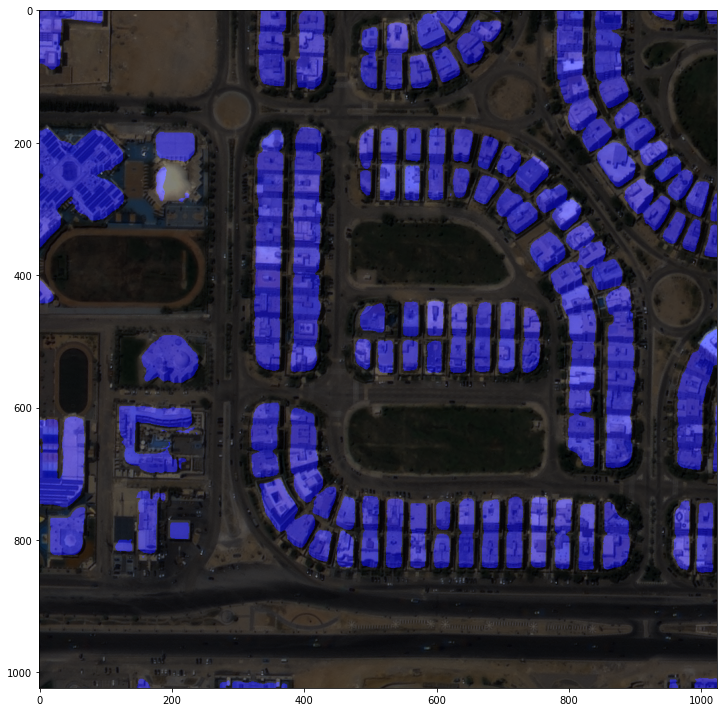

In [16]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


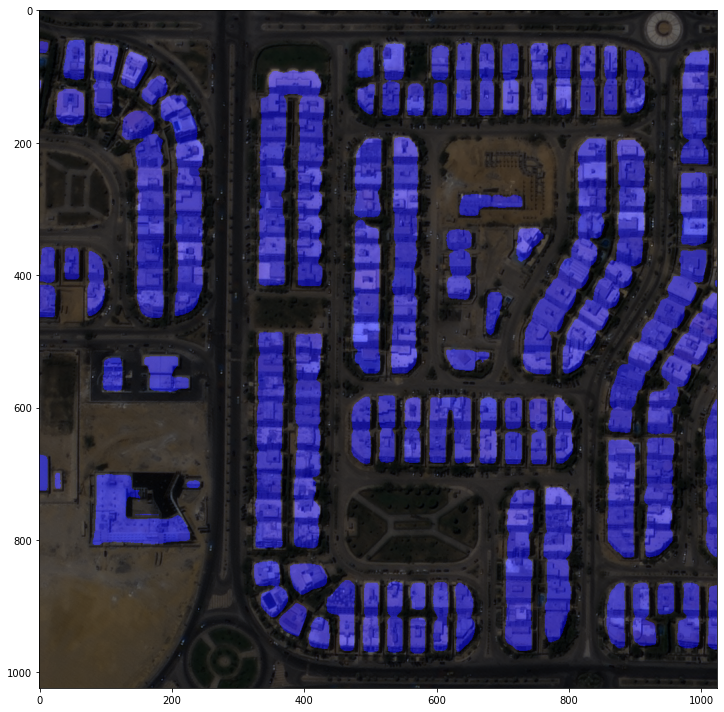

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


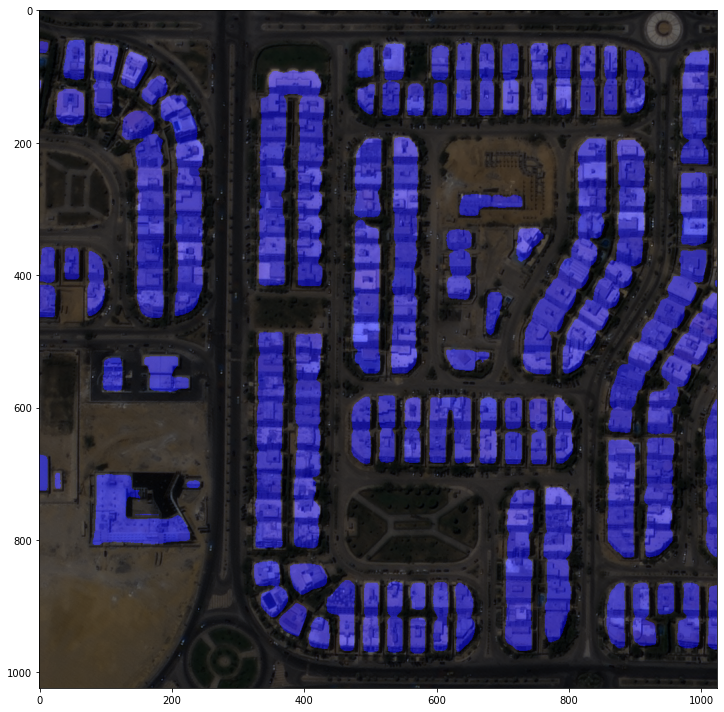

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


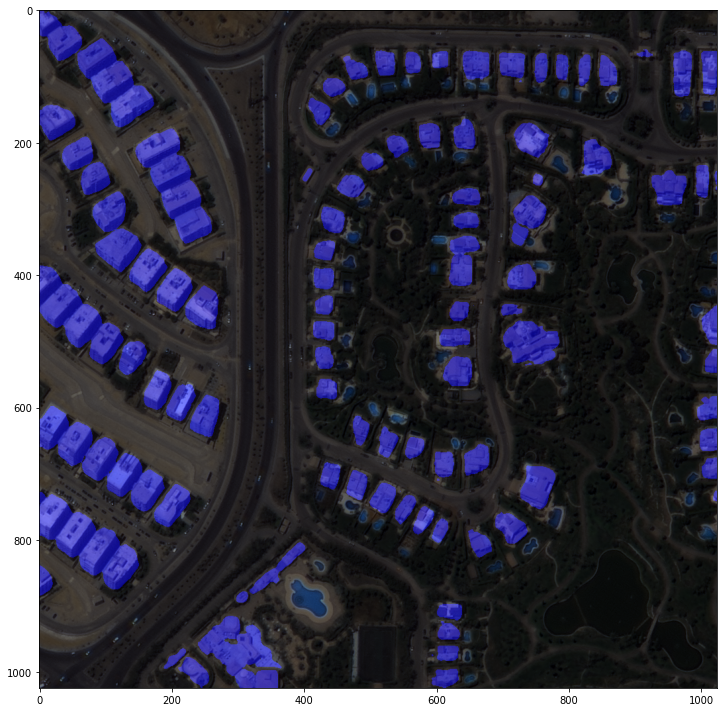

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


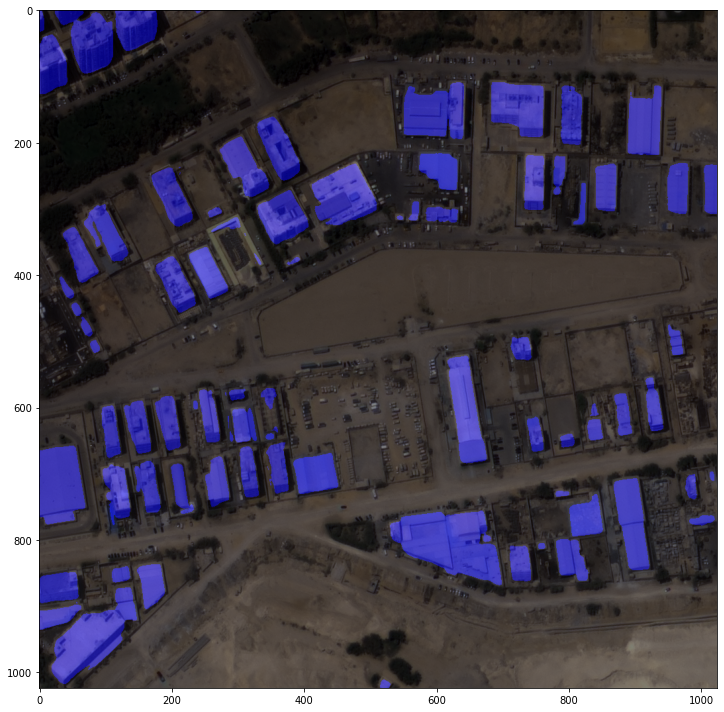

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


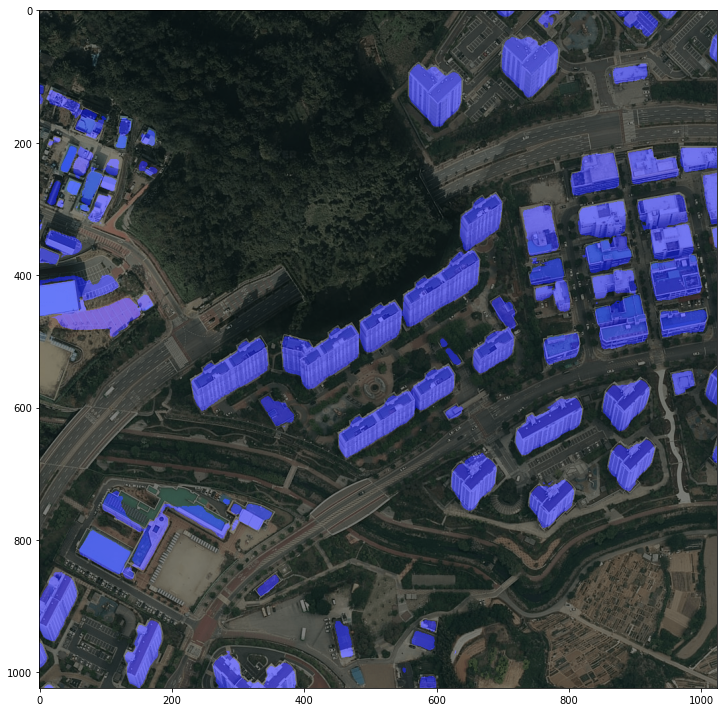

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


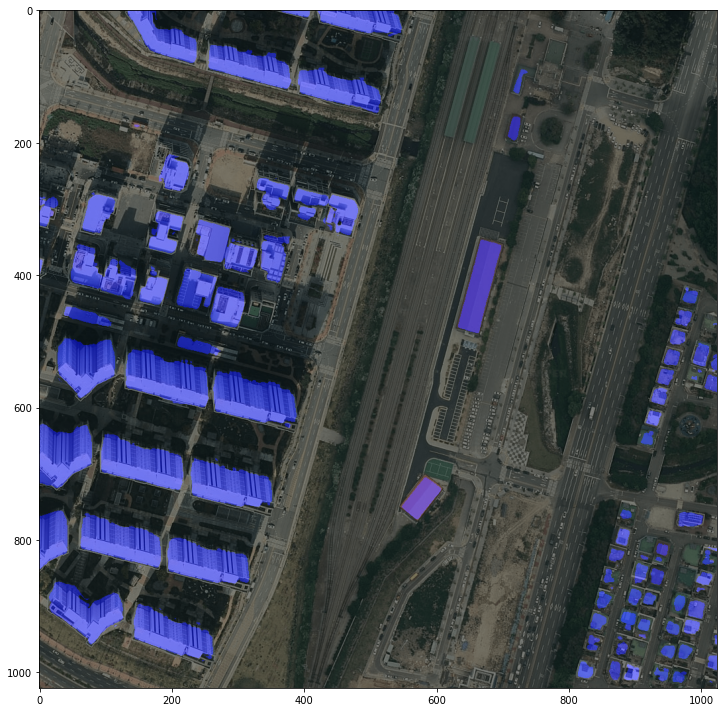

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


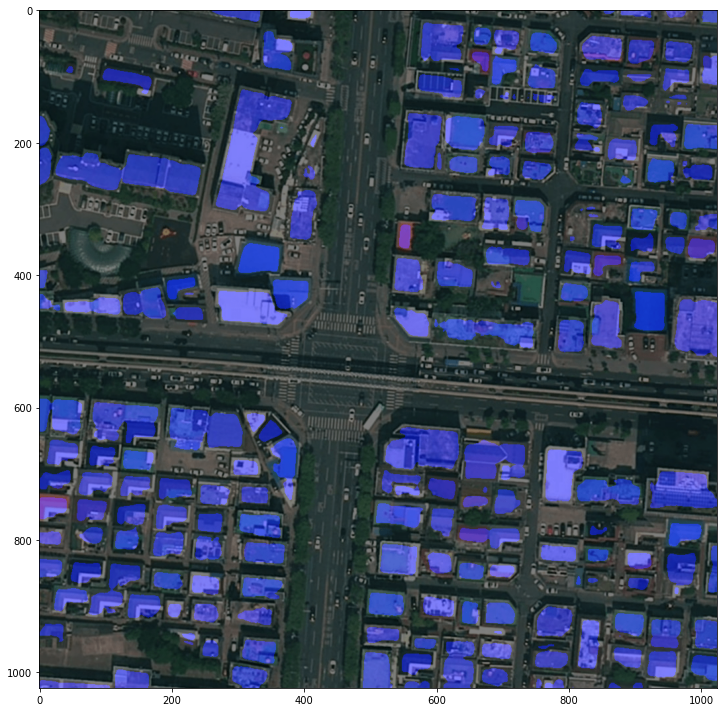

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_10000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)